# **Proyecto Final IA. Airline Delays Classification**
Sergio Andrés Castellanos Landazábal

In [17]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import decomposition
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn import svm

En primer lugar, se lee el dataframe pequeño que se encuentra en kaggle https://www.kaggle.com/threnjen/2019-airline-delays-and-cancellations?select=train_test_small.csv. Ya que el dataset es muy grande este se revuelve y se toman los primeros 2000 datos.

In [47]:
ADelaydf = pd.read_csv("train_test_small.csv", sep=',', nrows=2000)
ADelaydf=sklearn.utils.shuffle(ADelaydf)
ADelaydf.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,DEP_BLOCK,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
1809,1,3,0,2,AFTERNOON,2,180,124,United Air Lines Inc.,23400,46218,5228,3103410,8501631,0.000254,0.000229,20,Chicago O'Hare International,41.978,-87.906,Albuquerque International Sunport,0.22,1.0,3.9,34.0,9.84
365,1,7,0,2,AFTERNOON,5,112,143,Southwest Airlines Co.,13056,107363,5873,1903352,13382999,0.000062,0.000099,14,McCarran International,36.080,-115.152,Phoenix Sky Harbor International,0.00,0.0,0.0,65.0,2.91
251,1,7,0,7,AFTERNOON,3,112,175,Southwest Airlines Co.,13056,107363,5873,1903352,13382999,0.000062,0.000099,3,McCarran International,36.080,-115.152,Friendship International,0.00,0.0,0.0,65.0,2.91
193,1,7,1,2,AFTERNOON,3,112,185,Alaska Airlines Inc.,13056,20315,717,1903352,2884187,0.000032,0.000175,1,McCarran International,36.080,-115.152,Seattle International,0.00,0.0,0.0,65.0,2.91
1407,1,5,0,4,EVENING,3,64,146,Alaska Airlines Inc.,10155,20315,5024,1960746,2884187,0.000032,0.000175,8,Seattle International,47.447,-122.306,San Francisco International,0.00,0.0,0.0,61.0,7.61


Se toman las características del dataset:
* DAY_OF_WEEK
* DEP_BLOCK MORNING AFTERNOON EVENING MIDDAY LATE_NIGHT
*CONCURRENT_FLIGHTS
*NUMBER_OF_SEATS
*CARRIER_NAME
*AIRLINE_AIRPORT_FLIGHTS_MONTH
*PLANE_AGE
*DEPARTING_AIRPORT
*PRCP
*TMAX
*AWND

En este caso no se toma la caracteristica del mes porque el dataset pequeño es solo de enero.

In [48]:
X= ADelaydf[['DAY_OF_WEEK','DEP_BLOCK','CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRLINE_AIRPORT_FLIGHTS_MONTH','PLANE_AGE','DEPARTING_AIRPORT','PRCP','TMAX','AWND']].values
Y = ADelaydf[['DEP_DEL15']].values

A continuación se realiza el preprocesamiento del dataset para las columnas DEP_BLOCK, CARRIER_NAME y DEPARTING_AIRPORT, se pasan a valores númericos como se observa a continuación.

In [49]:
#Columna DEP_BLOCK
for i in range(0,len(X)):
 if str(X[i][1]) == "MORNING":
  X[i][1]=1
 elif str(X[i][1]) == "AFTERNOON":
  X[i][1]=2
 elif str(X[i][1]) == "EVENING":
  X[i][1]=3
 elif str(X[i][1]) == "MIDDAY":
  X[i][1]=4
 else:
  X[i][1]=5

#Columna CARRIER_NAME
# A continuación se hallan los valores únicos de la columna y se realiza un
# diccionario.

U_CN=ADelaydf['CARRIER_NAME'].unique()
aux_list= range(len(U_CN))
zip_iterator= zip(U_CN,aux_list)
Dict_CN= dict(zip_iterator)

for i in range(0,len(X)):
    aux= str(X[i][4])
    X[i][4]= Dict_CN[aux]

#Columna DEPARTING_AIRPORT
# A continuación se hallan los valores únicos de la columna y se realiza un
# diccionario.

U_DA=ADelaydf['DEPARTING_AIRPORT'].unique()
aux_list= range(len(U_DA))
zip_iterator= zip(U_DA,aux_list)
Dict_DA= dict(zip_iterator)

for i in range(0,len(X)):
    aux= str(X[i][7])
    X[i][7]= Dict_DA[aux]

Con los archivos limpios se crea un nuevo csv.

In [50]:
new_array = np.append(X, Y, axis=1)
df = pd.DataFrame(new_array)
df.to_csv('cleandata.csv')

Posteriormente, se realiza la normalización de las características con el método MinMaxScaler y StandarScaler.

In [51]:
#Método MinMaxScaler
mm_scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (-1,1))
mm_scaler.fit(X)
X_mmscaled = mm_scaler.transform(X)

#Método StandardScaler
s_scaler = StandardScaler()
s_scaler.fit(X)
X_sscaled = s_scaler.transform(X)

Luego, se realiza PCA a las características normalizadas, específicamente se reduce a 10 características.

In [52]:
pca = decomposition.PCA(n_components=9, svd_solver='full')
pca.fit(X_mmscaled)
X_mmpca = pca.transform(X_mmscaled)
print(sum(pca.explained_variance_ratio_[0:9]))
print("varianza explicada por cada caracteristica después de PCA:",pca.explained_variance_ratio_)

pca.fit(X_sscaled)
X_spca = pca.transform(X_sscaled)
print(sum(pca.explained_variance_ratio_[0:9]))
print("varianza explicada por cada caracteristica después de PCA:",pca.explained_variance_ratio_)

X_train, X_test, y_train, y_test = train_test_split(X_mmpca, Y, random_state=0)

0.9934848079099791
varianza explicada por cada caracteristica después de PCA: [0.34616362 0.18163149 0.12661575 0.11482854 0.07754263 0.05538005
 0.04520745 0.02692308 0.01919217]
0.9914118944549161
varianza explicada por cada caracteristica después de PCA: [0.28283934 0.19023665 0.11441445 0.10729434 0.09412136 0.07806874
 0.05759235 0.03913932 0.02770535]


Finalmente, se selecciona la normalización MinMaxScaler, ya que el valor de varianza es un poco mejor.

# **Redes Neunorales**

En primer lugar, se halla que activation y solver nos da el mejor score para esta solución. Como se observa a continuación, con identity y adam obtenemos el mayor score 0.8. 

In [53]:
activations =['identity', 'logistic', 'tanh', 'relu']
solvers = ["lbfgs", "sgd","adam"]
max_score= 0

for i in activations:
  for j in solvers:
    clf_MLP = MLPClassifier(activation=i, solver=j, max_iter=10000, random_state=1)
    clf_MLP.fit(X_train, np.ravel(y_train))
    score= clf_MLP.score(X_test, y_test)
    if(max_score < score):
      max_score = score
      best_a= i
      best_s= j

print("max_score",max_score)
print("best_Activation",best_a)
print("best_Solver",best_s)

max_score 0.838
best_Activation identity
best_Solver adam


Posteriormente, se iteran las capas ocultas y se observa que con 99 capas es suficiente.

In [54]:
max_score=0
for i in range(1,100):
  clf_MLP = MLPClassifier(activation=best_a, solver=best_s, hidden_layer_sizes=i, max_iter=10000, random_state=1)
  clf_MLP.fit(X_train, np.ravel(y_train))
  score= clf_MLP.score(X_test, y_test)
  if(max_score < score):
    max_score = score
    best_l= i

print("max_score",max_score)
print("Best layer",best_l)

max_score 0.842
Best layer 99


Luego, se itera el parámetro learning rate init. Hallando que el default 0,001 es suficiente para la solución.

In [55]:
max_score=0
for i in np.linspace(0.001,0.1,100):
  clf_MLP = MLPClassifier(activation=best_a, solver=best_s, hidden_layer_sizes=best_l, learning_rate_init=i, max_iter=10000, random_state=1)
  clf_MLP.fit(X_train, np.ravel(y_train))
  score= clf_MLP.score(X_test, y_test)
  if(max_score < score):
    max_score = score
    best_lr= i

print("max_score",max_score)
print("Best Learning Rate:",best_lr)

max_score 0.842
Best Learning Rate: 0.001


Finalmente, se obtienen las métricas de evaluación, coeficiente de Matthews, F1 Score y el porcentaje de ROC. Obteniendo un F1 Score de 0.84, un área bajo la curva de ROC de 78% y un coeficiente de Matthews de 0.5.

Score: 0.842
Coeficiente de Matthews: 0.5056921465603261
F1 Score:  0.842


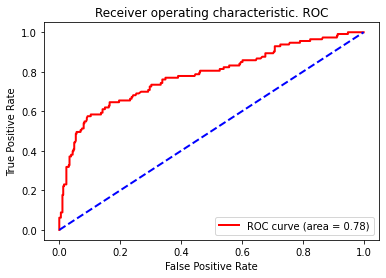

In [56]:
clf_MLP = MLPClassifier(activation=best_a, solver=best_s, hidden_layer_sizes=best_l, learning_rate_init=best_lr, max_iter=10000, random_state=1)
clf_MLP.fit(X_train, np.ravel(y_train))
print('Score:',max_score)
y_test_predicted = clf_MLP.predict(X_test)
y_test_scores = clf_MLP.predict_proba(X_test)
print('Coeficiente de Matthews: '+ str(matthews_corrcoef(y_test, y_test_predicted)))
print("F1 Score: ", f1_score(y_test, y_test_predicted, average='micro'))
fpr,tpr,thresholds = roc_curve(y_test, y_test_scores[:,1])
roc_auc=roc_auc_score(y_test, y_test_scores[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic. ROC')
plt.legend(loc="lower right")
plt.show()

# **Máquinas de soporte vectorial**

Por último, el clasificador svm. Para este clasificador se prueban todos los kernel, obteniendo el mejor resultado con poly

In [57]:
kernels =['linear', 'poly', 'rbf', 'sigmoid']
max_score=0
for i in kernels:
  Svm = svm.SVC(kernel= i)
  Svm.fit(X_train, np.ravel(y_train))
  score= Svm.score(X_test, y_test)
  if(max_score < score):
    max_score = score
    best_k= i
print("max_score",max_score)
print("Best Kernel:",best_k)

max_score 0.826
Best Kernel: poly


Finalmente, se obtienen las métricas de evaluación, coeficiente de Matthews, F1 Score y el porcentaje de ROC. Obteniendo un F1 Score de 0.82, un área bajo la curva de ROC de 77% y un coeficiente de Matthews de 0.45.

Score: 0.826
Coeficiente de Matthews: 0.45549110090554507
F1 Score:  0.826


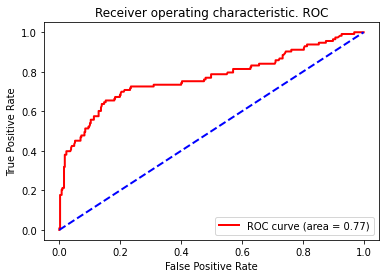

In [58]:
Svm = svm.SVC(kernel= best_k)
Svm.fit(X_train, np.ravel(y_train))
print('Score:',max_score)
y_test_predicted = Svm.predict(X_test)
y_test_scores = Svm.decision_function(X_test)
coef_mattews= matthews_corrcoef(y_test, y_test_predicted)
print('Coeficiente de Matthews: '+ str(matthews_corrcoef(y_test, y_test_predicted)))
print("F1 Score: ", f1_score(y_test, y_test_predicted, average='micro'))
fpr,tpr,thresholds = roc_curve(y_test, y_test_scores)
roc_auc=roc_auc_score(y_test, y_test_scores)
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic. ROC')
plt.legend(loc="lower right")
plt.show()